# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba

In [2]:
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.alpha"] = 0.5

pd.set_option('display.max_colwidth', None)

**Note on Model Application**

The dataset was processed using the [EyewearCounter](https://github.com/qksolov/eyewear-counter) model, which identifies the number of people in a photo wearing regular glasses, sunglasses, or no eyewear. A standard limit of detecting up to 4 faces per photo was applied during inference. Due to rate limits imposed by Wikidata and Wikimedia Commons on the number of requests per second, the model was applied only to data entries with valid and plausible photo creation dates.

In [3]:
# input_df = pd.read_parquet('/kaggle/input/notable-people-dataset-wikidata-based/npd_wikidata.parquet')

# mask = input_df['date_of_image'].notna()
# age = ((input_df.loc[mask, 'date_of_image'] - input_df.loc[mask, 'date_of_birth']).dt.days / 365.25)
# valid_death = (
#     input_df.loc[mask, 'date_of_death'].isna() |
#     (input_df.loc[mask, 'date_of_image'] <= input_df.loc[mask, 'date_of_death'])
# )
# img_df = input_df.loc[mask].loc[(age >= 3) & (age <= 99) & valid_death]
# img_df = img_df.reset_index(drop=True)


# !pip install eyewear-counter
# from eyewear_counter import EyewearCounter, generate_report

# image_urls = df['image_url'].to_list()

# model = EyewearCounter()
# pred, err = model.run(image_urls)

# df, _, _ = generate_report(model.results, err, df_input=img_df)
# df = df.rename(columns={'В очках':'glasses', 'Без очков':'plain', 'В солнцезащитных очках':'sunglasses'})

In [3]:
df = pd.read_parquet('../data/eyewear_wikidata.parquet')

# Overall Analysis

In [4]:
df.sample(5)

,wikidata_url,label,name_in_native_languages,pseudonyms,sex_or_gender,date_of_birth,place_of_birth,country_of_birth,date_of_death,place_of_death,...,citizenships,occupations,occupation_groups,awards,signature_url,image_url,date_of_image,glasses,plain,sunglasses
4265,http://www.wikidata.org/entity/Q1708510,Josh Thompson,<NA>,<NA>,male,1978-01-23,Cedarburg,United States,NaT,<NA>,...,United States,singer-songwriter; musician,Arts & Culture,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/JoshThompson.jpg,2010-07-25,0,1,0
105,http://www.wikidata.org/entity/Q10283066,Flávio Fachel,<NA>,<NA>,male,1965-08-03,Porto Alegre,Brazil,NaT,<NA>,...,Brazil,news presenter; journalist,Public Figures,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/AvatarFF1.jpg,2012-01-09,0,1,0
931,http://www.wikidata.org/entity/Q111342732,Eugénia Tabosa,<NA>,<NA>,female,1931-12-16,Lisbon,Portugal,2022-01-30,<NA>,...,Portugal,writer; painter,Arts & Culture,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/Etabosa-com-cravos.jpg,2014-07-13,1,0,0
10439,http://www.wikidata.org/entity/Q4273916,Eugenia Magaril,<NA>,<NA>,female,1902-06-21,Vitebsk,Belarus,1987-02-07,Saint Petersburg,...,Soviet Union; Russian Empire,painter,Arts & Culture,<NA>,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/Magaril.jpg,1922-01-01,0,1,0
4550,http://www.wikidata.org/entity/Q1798017,Mark Ravenhill,<NA>,<NA>,male,1966-06-07,England,United Kingdom,NaT,<NA>,...,United Kingdom,screenwriter; playwright; journalist; stage actor; theatrical director,Arts & Culture; Public Figures,Europe Theatre Prize,<NA>,http://commons.wikimedia.org/wiki/Special:FilePath/MarkRavenhill.JPG,2011-05-14,0,1,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17345 entries, 0 to 17344
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   wikidata_url              17345 non-null  string        
 1   label                     17345 non-null  string        
 2   name_in_native_languages  3464 non-null   string        
 3   pseudonyms                697 non-null    string        
 4   sex_or_gender             17318 non-null  string        
 5   date_of_birth             17345 non-null  datetime64[ns]
 6   place_of_birth            17300 non-null  string        
 7   country_of_birth          17345 non-null  string        
 8   date_of_death             2960 non-null   datetime64[ns]
 9   place_of_death            2364 non-null   string        
 10  country_of_death          2364 non-null   string        
 11  citizenships              16445 non-null  string        
 12  occupations       

In [4]:
df['sex'] = df['sex_or_gender'].apply(
    lambda x: x if pd.notna(x) and x in ['male', 'female'] else pd.NA)

df['year_of_birth'] = df['date_of_birth'].dt.year
df['year_of_death'] = df['date_of_death'].dt.year
df['year_of_image'] = df['date_of_image'].dt.year
df['age_on_image'] = (df['date_of_image'] - df['date_of_birth']).dt.days // 365

df['glasses'] = (df['glasses'] > 0).astype(int)
df['plain'] = (df['plain'] > 0).astype(int)
df['sunglasses'] = (df['sunglasses'] > 0).astype(int)
df['class_count'] = df[['glasses', 'plain', 'sunglasses']].sum(axis=1).clip(0,2)

class_columns = ['glasses', 'plain', 'sunglasses']
df_long = df.melt(id_vars=[col for col in df.columns if col not in class_columns],
                  value_vars=class_columns, var_name='class', value_name='value')
df_long = df_long[df_long['value'] > 0].reset_index(drop=True).drop(columns=['value'])

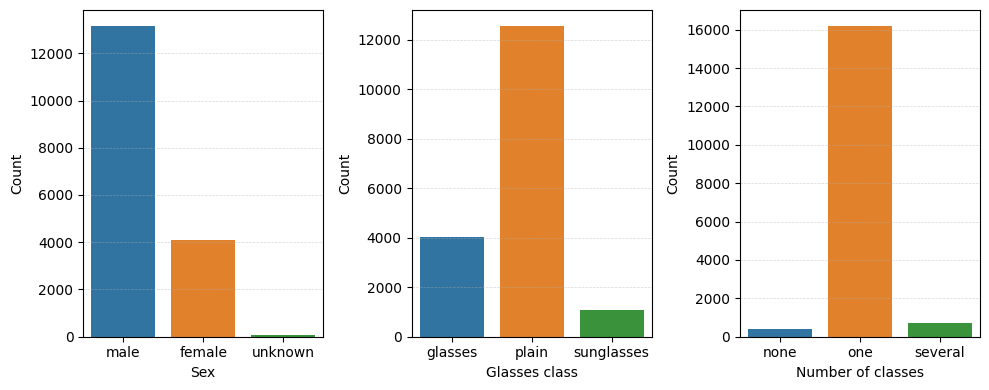

In [5]:
df_bar = df.copy()
df_bar['sex'] = df_bar['sex'].fillna('unknown')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

sns.countplot(data=df_bar, x='sex', ax=ax1, hue='sex', legend=False)
ax1.set_xlabel('Sex')
ax1.set_ylabel('Count')

sns.countplot(data=df_long, x='class', ax=ax2, hue='class')
ax2.set_xlabel('Glasses class')
ax2.set_ylabel('Count')

sns.countplot(
    data=df, x='class_count',    
    hue='class_count', legend=False, palette='tab10',
    ax=ax3
)
ax3.set_xlabel('Number of classes')
ax3.set_ylabel('Count')
ax3.set_xticks([0, 1, 2])
ax3.set_xticklabels(['none', 'one', 'several'])

plt.tight_layout()
plt.show()

In [6]:
gender_summary = df['sex'].value_counts(dropna=False).to_frame(name='count')
gender_summary['percentage'] = (df['sex'].value_counts(normalize=True, dropna=False) * 100).round(1).astype(str) + '%'
gender_summary.index = gender_summary.index.fillna('unknown')
print("Gender Distribution:")
display(gender_summary)


class_summary = df_long['class'].value_counts().to_frame(name='count')
class_summary['percentage'] = (df_long['class'].value_counts(normalize=True, dropna=False) * 100).round(1).astype(str) + '%'
print("\nGlasses Class Distribution:")
display(class_summary)


class_count_summary = df['class_count'].value_counts().to_frame(name='count')
class_count_summary['percentage'] = (df['class_count'].value_counts(normalize=True, dropna=False) * 100).round(1).astype(str) + '%'
class_count_summary.index = ['none', 'one', 'several'] 
print("\nNumber of Classes Per Image:")
display(class_count_summary)

Gender Distribution:


,count,percentage
sex,,
male,13173,75.9%
female,4109,23.7%
unknown,63,0.4%



Glasses Class Distribution:


,count,percentage
class,,
plain,12571,71.0%
glasses,4038,22.8%
sunglasses,1087,6.1%



Number of Classes Per Image:


,count,percentage
none,16217,93.5%
one,718,4.1%
several,410,2.4%


# Demographic Analysis

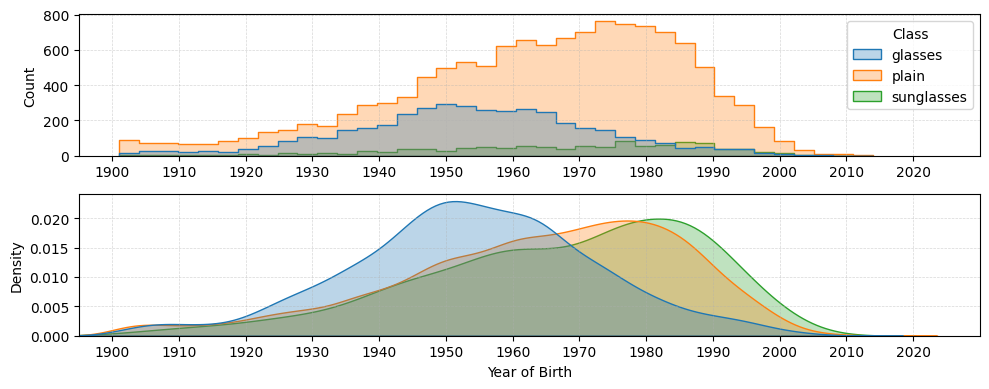

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 4), tight_layout=True, sharex=True)

sns.histplot(df_long, x="year_of_birth", hue="class", element="step", binwidth=3, ax=ax1, alpha=0.3)
sns.kdeplot(df_long, x="year_of_birth", fill=True, hue='class', common_norm=False, ax=ax2, alpha=0.3, legend=False)

tick_values = range(1900, 2030, 10)
for ax in [ax1, ax2]:
    ax.set_xlim(1895, 2030)
    ax.set_xticks(tick_values)
    ax.tick_params(axis='x', labelbottom=True)

glasses_patch = mpatches.Patch(facecolor=to_rgba('C0', alpha=0.3), edgecolor='C0', label='glasses')
plain_patch = mpatches.Patch(facecolor=to_rgba('C1', alpha=0.3), edgecolor='C1', label='plain')
sunglasses_patch = mpatches.Patch(facecolor=to_rgba('C2', alpha=0.3), edgecolor='C2', label='sunglasses')

leg = ax1.get_legend()
leg.set_title("Class") 

ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, which='both')
ax2.set_xlabel('Year of Birth')
plt.show()

In [14]:
def mode(x):
    modes = x.mode()
    return modes[0] if not modes.empty else None


def q25(x):
    return x.quantile(0.25)


def q75(x):
    return x.quantile(0.75)

In [15]:
print('Birth Year Statistics by Class:')
df_long.pivot_table(
    index='class',
    values='year_of_birth',
    aggfunc=['mean', 'median', mode, 'min', 'max'],
    margins=True,              
    margins_name='all'
).apply(np.floor).astype(int).droplevel(level=1, axis=1)

Birth Year Statistics by Class:


,mean,median,mode,min,max
class,,,,,
glasses,1953,1954,1958,1901,2008
plain,1963,1967,1978,1901,2014
sunglasses,1967,1970,1976,1901,2005
all,1961,1963,1961,1901,2014


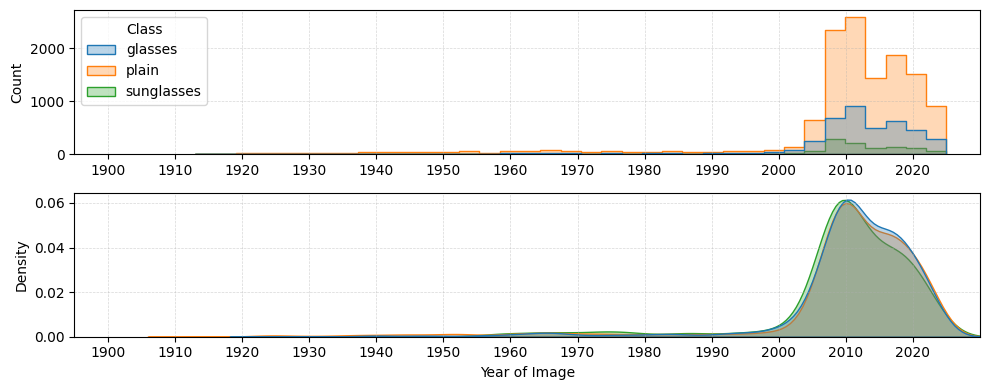

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 4), tight_layout=True, sharex=True)

sns.histplot(df_long, x="year_of_image", hue="class", element="step", binwidth=3, ax=ax1, alpha=0.3)
sns.kdeplot(df_long, x="year_of_image", fill=True, hue='class', common_norm=False, ax=ax2, alpha=0.3, legend=False)

tick_values = range(1900, 2030, 10)
for ax in [ax1, ax2]:
    ax.set_xlim(1895, 2030)
    ax.set_xticks(tick_values)
    ax.tick_params(axis='x', labelbottom=True)

leg = ax1.get_legend()
leg._loc = 2
leg.set_title("Class") 

ax2.set_xlabel('Year of Image')
plt.show()

In [32]:
print('Image Year Statistics by Class')
df_long.pivot_table(
    index='class',
    values='year_of_image',
    aggfunc=['mean', 'median', mode, 'min', 'max'],
    margins=True,              
    margins_name='all'
).apply(np.floor).astype(int).droplevel(level=1, axis=1)

Image Year Statistics by Class


,mean,median,mode,min,max
class,,,,,
glasses,2010,2012,2010,1925,2025
plain,2009,2012,2009,1913,2025
sunglasses,2009,2011,2009,1944,2025
all,2009,2012,2009,1913,2025


In [9]:
print("Earliest Images by Class")
min_years = df_long.groupby('class')['year_of_image'].transform('min')  
df_show_min_years = df_long[df_long['year_of_image'] == min_years]
df_show_min_years = df_show_min_years.groupby('class').first().reset_index()
df_show_min_years[['label', 'class', 'date_of_image', 'image_url']]

Earliest Images by Class


,label,class,date_of_image,image_url
0,Maud Morgan,glasses,1925-01-01,http://commons.wikimedia.org/wiki/Special:FilePath/MaudCabot1925.png
1,Leonid Pustovalov,plain,1913-01-02,http://commons.wikimedia.org/wiki/Special:FilePath/1913-PustovalovLV.jpg
2,Zissis Skaros,sunglasses,1944-10-12,http://commons.wikimedia.org/wiki/Special:FilePath/SKAROS-1944.jpg


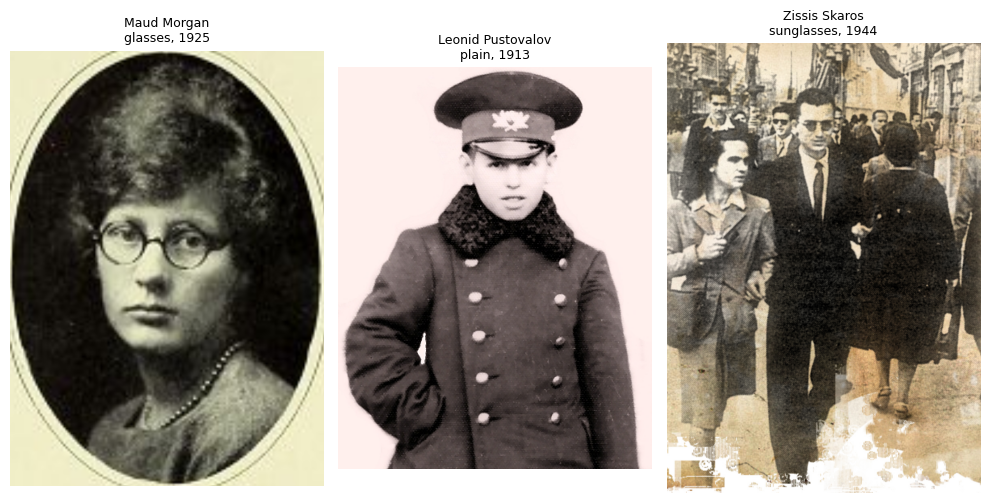

In [44]:
import requests
from PIL import Image
from io import BytesIO

headers = {"User-Agent": "Mozilla/5.0"}

n = len(df_show_min_years)
fig, axes = plt.subplots(1, n, figsize=(10, 5))

if n == 1:
    axes = [axes]

for ax, (_, row) in zip(axes, df_show_min_years.iterrows()):
    url = row['image_url']
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()

    content_type = response.headers.get("Content-Type", "")
    if not content_type.startswith("image"):
        raise ValueError(f"URL did not return an image: {content_type}")

    image = Image.open(BytesIO(response.content)).convert("RGB")
    ax.imshow(image)
    ax.set_title(f"{row['label']}\n{row['class']}, {row['date_of_image'].year}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

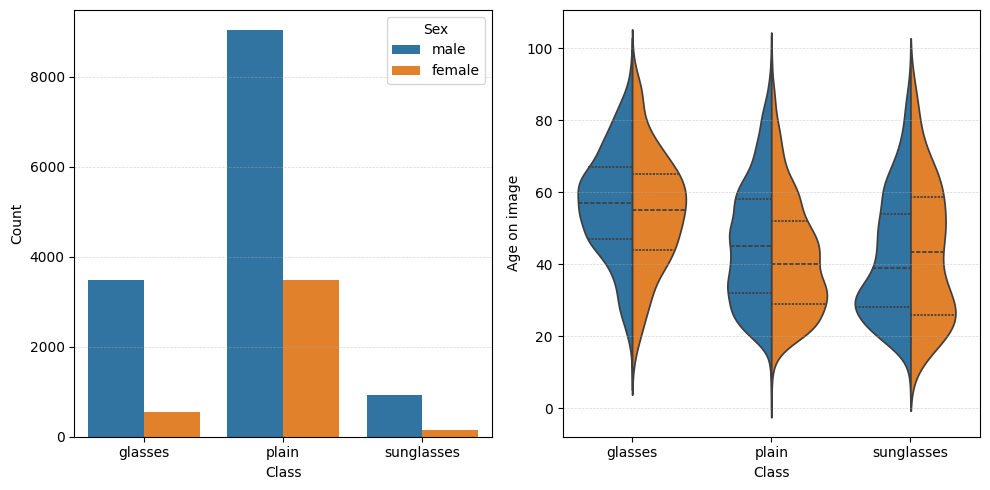

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(
    data=df_long,
    x='class',
    hue='sex',
    ax=ax1,
)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.legend(title='Sex')

sns.violinplot(
    data=df_long,
    x='class',
    y='age_on_image',
    hue='sex',
    split=True,
    inner="quart",
    legend=False,
    ax=ax2,
)
ax2.set_ylabel('Age on image')
ax2.set_xlabel('Class')

ax.yaxis.grid(False)
plt.tight_layout()
plt.show()

In [46]:
pivot_abs = df_long.pivot_table(index='sex', columns='class', aggfunc='size')
pivot_pct = pivot_abs.div(pivot_abs.sum(axis=1), axis=0) * 100

pivot_pct = pivot_pct.round(1).astype(str) + '%'
result = pivot_abs.astype(str) + ' (' + pivot_pct + ')'

print('Class Distribution by Sex (Count and Percentage):')
result

Class Distribution by Sex (Count and Percentage):


class,glasses,plain,sunglasses
sex,,,
female,542 (13.0%),3484 (83.3%),158 (3.8%)
male,3487 (25.9%),9037 (67.2%),923 (6.9%)


In [47]:
print('Age on Image Distribution Statistics by Class:')
df_long.pivot_table(
    index='class',
    values='age_on_image',
    aggfunc=['mean', mode, 'min', q25, 'median', q75, 'max', 'std'],
    margins=True,
    margins_name='overall'
).round().astype(int).droplevel(level=1, axis=1)

Age on Image Distribution Statistics by Class:


,mean,mode,min,q25,median,q75,max,std
class,,,,,,,,
glasses,56,60,11,46,57,67,97,15
plain,45,34,3,31,43,57,98,17
sunglasses,42,32,10,28,39,55,94,17
overall,47,49,3,33,47,60,98,17


# Occupational Analysis

In [10]:
df_prof = df_long.copy()
df_prof = df_prof.assign(
    occupations_split = df_prof['occupation_groups'].str.split(';')
).explode('occupations_split')

df_prof['occupation_group'] = df_prof['occupations_split'].str.strip()
occupation_group = df_prof['occupation_group'].unique()

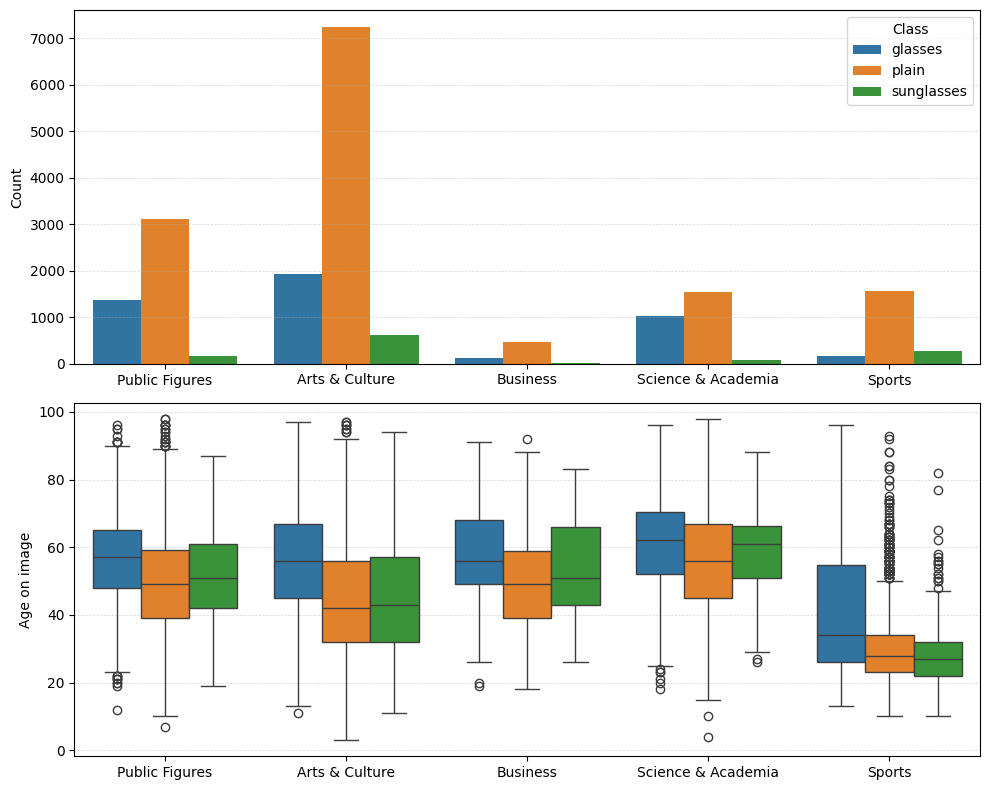

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

sns.countplot(
    data=df_prof,
    x='occupation_group',
    hue='class',
    ax=ax1,
)
ax1.set_xlabel('')
ax1.set_ylabel('Count')
leg = ax1.get_legend()
leg.set_title("Class") 

sns.boxplot(
    data=df_prof,
    x='occupation_group',
    y='age_on_image',
    hue='class', ax=ax2, legend=False)
ax.yaxis.grid(False)

plt.ylabel('Age on image')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [50]:
pivot_abs = df_prof.pivot_table(index='occupation_group', columns='class', aggfunc='size')
pivot_pct = pivot_abs.div(pivot_abs.sum(axis=1), axis=0) * 100
pivot_abs.index.name = 'occupation group'
pivot_pct = pivot_pct.round(1).astype(str) + '%'
result = pivot_abs.astype(str) + ' (' + pivot_pct + ')'
print('Class Distribution by Occupation Group (Count and Percentage):')
result

Class Distribution by Occupation Group (Count and Percentage):


class,glasses,plain,sunglasses
occupation group,,,
Arts & Culture,1927 (19.7%),7247 (73.9%),626 (6.4%)
Business,135 (21.4%),471 (74.6%),25 (4.0%)
Public Figures,1382 (29.6%),3116 (66.7%),174 (3.7%)
Science & Academia,1035 (39.2%),1535 (58.1%),72 (2.7%)
Sports,170 (8.4%),1576 (77.9%),276 (13.6%)


In [51]:
age_pivot = df_prof.pivot_table(
    index='occupation_group',
    columns='class',
    values='age_on_image',
    aggfunc='mean',
    fill_value=None,           
    margins=True,              
    margins_name='overall'
).round(1)
age_pivot.index.name = 'occupation group'
print('Mean Age by Class and Occupation Groups:')
age_pivot

Mean Age by Class and Occupation Groups:


class,glasses,plain,sunglasses,overall
occupation group,,,,
Arts & Culture,55.7,44.5,44.9,46.7
Business,58.0,49.7,54.4,51.7
Public Figures,56.5,49.7,51.4,51.8
Science & Academia,61.2,55.7,58.6,57.9
Sports,40.4,30.9,28.6,31.4
overall,56.7,45.6,43.1,48.0


# Geographic Analysis

In [52]:
top_countries = df_long['country_of_birth'].value_counts().head(10).index.tolist()
df_top_countries = df_long[df_long['country_of_birth'].isin(top_countries)]

pivot_countries = df_top_countries.pivot_table(
    index='country_of_birth', 
    columns='class', 
    aggfunc='size'
).astype(int)

pivot_countries.index.name = 'country of birth'
pivot_countries = pivot_countries.reindex(top_countries)

print('Count of Individuals by Class in Top 10 Birth Countries:')
pivot_countries.style.background_gradient(cmap='Blues', axis=0)

Count of Individuals by Class in Top 10 Birth Countries:


class,glasses,plain,sunglasses
country of birth,,,
United States,738,2626,314
Germany,415,698,37
France,183,649,37
United Kingdom,155,538,50
India,174,501,50
Spain,206,477,30
Russia,122,432,32
Japan,52,445,64
Italy,130,374,29


# Summary & Observations

This analysis explores the predictions made by the eyewear classification model on a sample of notable individuals from Wikidata. Here are the key takeaways:

**Gender distribution**: The sample is notably skewed toward men (75.9%), which is important to keep in mind when interpreting results.

**Model outputs**: In most cases (93.5%), images were assigned a single class label (e.g., "plain", "glasses", or "sunglasses"), which is desirable given that the data describes individuals, not group photos.

**Class distribution**:
  - The majority of individuals were classified as having **no eyewear ("plain")** — 71.0%.
  - **Eyeglasses ("glasses")** appeared in 22.8% of the images.
  - **Sunglasses** were identified in 6.1% of cases.

**Birth year patterns by class**:
  - Those classified as wearing **glasses** tend to have earlier birth years (mode: 1958), while those with **sunglasses** are generally younger (mode: 1976).
  - This likely reflects generational differences in how eyewear is used and perceived.

**Image year distribution**:
  - Across all classes, most images were created or captured in the **21st century**, with little variation across eyewear types — confirming the dataset's modern bias.

**Gender vs eyewear**:
  - Men are more likely to appear wearing **glasses (25.9%)** than women (13.0%).
  - Women, on the other hand, are more frequently classified as **not wearing eyewear (83.3%)**.

**Age distribution by eyewear**:
  - People wearing **glasses** are on average significantly older (mean age: 56) than those without eyewear (mean: 45) or with **sunglasses** (mean: 42).
  - This matches social expectations — glasses are often associated with age, while sunglasses correlate more with youth or image.

**Occupational patterns**:
  - Individuals in **Science & Academia** are the most likely to wear **glasses** (39.2%).
  - In contrast, **Sports** figures have the **lowest proportion of glasses** (8.4%) and the **highest proportion of sunglasses** (13.6%).
  - This may partly reflect the inclusion of sports goggles or swimming glasses that resemble sunglasses in images, potentially affecting the model's predictions.

**Country-level variation**:
  - It is interesting to note that **Germany** shows a relatively high proportion of people classified as wearing glasses, compared to other countries.
  - This could be influenced by visual cultural norms, data coverage, or image types more prevalent in specific regions.

> **Note**:
> 
> This analysis is based on a subset of images associated with Wikidata entries, using model predictions. Since these predictions are automated, they may occasionally contain errors in classification.
>
> The sample is relatively small and should not be considered representative of the broader population — or even of all notable individuals. Furthermore, for many subgroups (e.g., certain countries or occupations), sample sizes may be too limited to support strong statistical conclusions. Interpretations should therefore be seen as exploratory and suggestive, not definitive.
